# Transfer Learning

For our next assignments, we will need to use pretrained neural networks in order to benefit from state of the art feature extraction. First, download the required data from the following [link](https://download.pytorch.org/tutorial/hymenoptera_data.zip). Before importing the weights of a pretrained network, we can use our previous convolutional neural network to see how well we perform on real-world data. If you obtained a working CNN train it using the provided dataset. Otherwise, you are welcome to use the fully connected classifier from the first exercise.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torch.optim as optim
import time
import os
import copy

plt.ion()   # interactive mode

In [2]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = '/Users/marissaposner/Downloads/hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# device = 'cpu'

torch.Size([3, 228, 906])


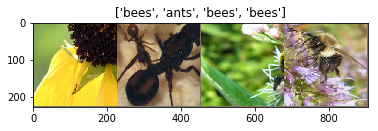

In [3]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    print(inp.shape)
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)  #clip/limit the values in an array
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

Notice that the images in this dataset are much larger. Make sure you adjust your network layer parameters accordingly. Second, use at most 5-10 epochs since training on larger images takes longer. Don't forget to train your network using the training dataset and evaluating the performance using the validation dataset.

# Your Best CNN Model

In [10]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        #############################################################################
        # TO DO:                                                                    #
        # Define the basic architecture of your network. You can use any combination#
        # of layers.                                                                #
        # In this function, you should only define the layers you intend to use.    #
        # Save each layer as a different *self variable*.                           #
        # This function has no return value.                                        #
        #############################################################################
        self.conv1 = nn.Conv2d(3, 16, 5)   #3rd argument is kernel size
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 32, 5)  #2nd argument is number of output channels (# of kernels)
        self.pool = nn.MaxPool2d(2, 2)   #after apply 2nd conv layer
        self.fc1 = nn.Linear(53*53*32,120) #pool and conv changed shape
        self.fc2 = nn.Linear(120, 2)  #2 is the num of values to output (ants & bees)
        #get down to shape that is 224 x 1 x1

    def forward(self, x):
        #############################################################################
        # TO DO:                                                                    #
        # Define the forward propagation of your network. Connect each layer to     #
        # the next and experiment with different activations, number of parameters  #
        # and depths. You can read about different activations in PyTorch at        #
        # https://pytorch.org/docs/stable/nn.html#non-linear-activation-functions   #
        # Return a single tensor after passing it through your network.             #
        # Hint: Shaping a multidimensional tensor into a vector can be achieved by: #
        # the method x.view()                                                       #
        #############################################################################
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        #print(x.shape)
        x = x.view(x.shape[0], -1) #indexing into vector, all other ones
        #print(x.shape)
        #print(x.shape) cant apply fully connected layer to a 3D tensor (can only apply to 1d vector)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        #print(x.shape)
        
        return x   #turns it into class probabilities
       
net = Net()

In [11]:
#############################################################################
# TO DO:                                                                    #
# Pick a loss function and optimizer from your network. Start with a cross- #
# entropy loss and stochastic gradient descent with 0.001 learning rate and #
# test the effect of different learning rates and momentum.                 #
# Use the documentation and create variables to hold the loss function and  #
# optimizer. The model will take them as inputs for the training process    #
#############################################################################
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
for epoch in range(5):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(dataloaders['train'], 0):
        # get the inputs
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 60 == 59:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 60))
            running_loss = 0.0

print('Finished Training')

[1,    60] loss: 0.697
[2,    60] loss: 0.693
[3,    60] loss: 0.693
[4,    60] loss: 0.693
[5,    60] loss: 0.693
Finished Training


In [12]:
total_correct = 0
total_images = 0
confusion_matrix = np.zeros([10,10], int)
with torch.no_grad():
    for data in dataloaders['val']:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total_images += labels.size(0)
        total_correct += (predicted == labels).sum().item()
        for i, l in enumerate(labels):
            confusion_matrix[l.item(), predicted[i].item()] += 1 

model_accuracy = total_correct / total_images * 100
print('Model accuracy on {0} test images: {1:.2f}%'.format(total_images, model_accuracy))

Model accuracy on 153 test images: 54.25%


Remeber we are trying to classify only two objects and model accuracy of 50% is just guessing randomly!

# Model Fine Tuning

Now, you will take ResNet18, which is a deep residual network with 18 layers. This 'shallow' network can be trained using CPU in reasonable time. Make sure you run 5-10 epochs only if you are indeed running on a CPU. For this exercise, you are provided with the training and evaluating functions needed. You are required to load ResNet18's architecture and weights from `torchvision.models` and replace the last fully connected layer to support outputing class probabilities for only two classes.

In [13]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=5):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [14]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

Load resnet18 and make the appropriate changes in order to support the given dataset. Define the criterion since the optimizer and learning rate are defined for you.

In [15]:
model_ft=torchvision.models.resnet18(pretrained=False)

In [19]:
model_ft.fc

Linear(in_features=512, out_features=1000, bias=True)

In [23]:
model_fr=models.resnet18(pretrained=True)
num_ftrs=model_ft.fc.in_features
model_ft.fc=nn.Linear(num_ftrs,2)

model_ft=model_ft.to(device)

criterion=nn.CrossEntropyLoss()

#observe that all parameters are being optimized
optimizer_ft=optim.SGD(model_ft.parameters(),lr=0.001, momentum=0.9)

#decay LR by a factor of 0.1 every 7 seconds
exp_lr_scheduler=lr_scheduler.StepLR(optimizer_ft,step_size=7,gamma=0.1)

In [24]:
# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [25]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=5)

Epoch 0/4
----------
train Loss: 0.7313 Acc: 0.5902
val Loss: 0.8479 Acc: 0.6536

Epoch 1/4
----------
train Loss: 0.6749 Acc: 0.6516
val Loss: 0.6551 Acc: 0.6928

Epoch 2/4
----------
train Loss: 0.7224 Acc: 0.5984
val Loss: 0.7108 Acc: 0.5817

Epoch 3/4
----------
train Loss: 0.7630 Acc: 0.5574
val Loss: 0.8193 Acc: 0.5882

Epoch 4/4
----------
train Loss: 0.9720 Acc: 0.5615
val Loss: 0.7013 Acc: 0.6797

Training complete in 8m 25s
Best val Acc: 0.692810
